### Build A Basic Chatbot with langgraph (graph)

In [43]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from dotenv import load_dotenv
from typing_extensions import TypedDict
import os
load_dotenv()


True

### State

In [44]:
##State class
class MyState(TypedDict):
    messages: Annotated[list[str], add_messages]
    

### tools

In [45]:

def addNumbers(a: int, b: int) -> int:
    '''Adds two numbers
    a: first number
    b: second number
    returns: sum of a and b
    '''
    return a + b


from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)


tools=[tool, addNumbers]


In [91]:
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0, model="openai/gpt-oss-20b")
llm_with_tools=llm.bind_tools(tools)



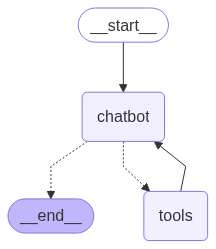

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display,Image
memory = MemorySaver()


def chatbot(state:MyState) :
    response = llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

graph_builder = StateGraph(MyState)
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools))


graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph=graph_builder.compile(memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [48]:
def ask_graph(query: str):
    response=graph.invoke({"messages": [query]}, config={"configurable": {"thread_id": 5}})
    for event in response['messages']:
        event.pretty_print()
        
    

In [49]:
ask_graph("whats latest ai news")

================================ Human Message =================================

whats latest ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_a715c359-ec24-41fc-9e9a-a95ee59522f4)
 Call ID: fc_a715c359-ec24-41fc-9e9a-a95ee59522f4
  Args:
    query: latest AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.finextra.com/newsarticle/46539/banks-set-to-accelerate-spend-on-ai-as-productivity-surges", "title": "Banks set to accelerate spend on AI as productivity surges - Finextra Research", "score": 0.76385427, "published_date": "Wed, 03 Sep 2025 23:02:11 GMT", "content": "/ai### Lloyds puts leadership team through AI training programme25 March 2025\n/security### Lloyds Banking Gro

In [57]:
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]



from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

docs=[WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]


text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder()
docs_split=text_splitter.split_documents(docs_list)
print(f"documents after splitting: {len(docs_split)}")

documents after splitting: 9


In [79]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import FastEmbedEmbeddings

# 1. Initialize embeddings (fast & free)
embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-small-en-v1.5")

# 2. Create ChromaDB vector store (local persistence)
vector_store = Chroma(
    collection_name="documents",
    embedding_function=embeddings,
    persist_directory="./chroma_db"  # stores DB on disk
)

# 3. Add your documents
vector_store.add_documents(docs_split)

# 4. Persist to disk
vector_store.persist()
print("✅ Documents added to ChromaDB and saved locally.")


/var/folders/6g/w462_jfj57339_fv01jwj6l00000gp/T/ipykernel_94300/4189101505.py:8: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


✅ Documents added to ChromaDB and saved locally.


/var/folders/6g/w462_jfj57339_fv01jwj6l00000gp/T/ipykernel_94300/4189101505.py:18: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_store.persist()


In [ ]:
query = "hello"
results = vector_store.similarity_search(query, k=10)

for i, res in enumerate(results, start=1):
    print(f"\nResult {i}:")
    print(res)  # show snippet


In [ ]:
vector_store.add_documents(docs_split)
vector_store.persist()

# 4. Directly get retriever (no VectorStoreIndexWrapper needed)
retriever = vector_store.as_retriever()

# 5. Run a query
query = "Explain LangGraph memory"
docs = retriever.invoke(query)

for i, doc in enumerate(docs, start=1):
    print(f"\nResult {i}: {doc.page_content[:300]}")

In [95]:
from typing import Literal
from langchain.pydantic_v1 import BaseModel, Field


class ResponseFormatter(BaseModel):
    """Route a user query to most relevant datasource."""

    data_source: Literal["vector_store", "tavily_search"] = Field(
        ...,
        description="Given a user query chose to route it to vector_store or tavliy_search",
    )
    
structured_llm=llm_with_tools.with_structured_output(ResponseFormatter) # type: ignore

In [96]:
from langchain_core.prompts import ChatPromptTemplate

system= "you are an expert in routing a user query to most relevant datasource, either vector_store or tavily_search, depending on user query route the user"
route_prompt=ChatPromptTemplate.from_messages([
    ("system",system),
    ("user","Decide whether to use vector_store or tavily_search to answer the question: {query}. Respond with a json object with a single field data_source whose value is either vector_store or tavily_search"),
])

question_router=route_prompt | structured_llm


In [100]:
question_router.invoke({"query":"what is prompt engineering? do web search"})

ResponseFormatter(data_source='tavily_search')